# DS-I Africa Tool-a-thon 2025: Tasks

For this activity you will prepare LST predictions for a city of interest and proceed to analyze human mobility trends for the given period.

You can refer to notebooks 1-5 for notes on the process, but these will not be required for the tool-a-thon.  



## 1. Set up your Google Colab environment

You can change runtimes on the Colab Notebook - Select the dropdown next to Connect on the top right hand corner > Change runtime type > ```T4 GPU or v2-8 TPU``` > save. Selecting this at the beginning will ensure seamless running of this notebook.

In [1]:
import sys
if 'google.colab' in sys.modules:
  # Clone the ibm-granite/granite-geospatial-land-surface-temperature GitHub
  !git clone https://github.com/Tamaragov/dsi-toolathon-2025-granite-geospatial-land-surface-temperature.git
  # Install the package
  !pip install ./dsi-toolathon-2025-granite-geospatial-land-surface-temperature
  # Change to the notebooks directory

Cloning into 'dsi-toolathon-2025-granite-geospatial-land-surface-temperature'...
remote: Enumerating objects: 196, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 196 (delta 21), reused 26 (delta 13), pack-reused 159 (from 1)
Receiving objects: 100% (196/196), 778.97 MiB | 49.01 MiB/s, done.
Resolving deltas: 100% (46/46), done.
Updating files: 100% (98/98), done.
Processing ./dsi-toolathon-2025-granite-geospatial-land-surface-temperature
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 4.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of lightning[pytorch-extra] to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.5/153.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
# If running on Colab you will be asked to restart the session. This is normal and you should do so.
# Only run this cell if running on Colab.
# Change to the notebooks directory
%cd dsi-toolathon-2025-granite-geospatial-land-surface-temperature/notebooks/
%pwd

/content/dsi-toolathon-2025-granite-geospatial-land-surface-temperature/notebooks


'/content/dsi-toolathon-2025-granite-geospatial-land-surface-temperature/notebooks'

## 2. Preprocess the data
Data for 5 cities:

```abuja_nga```
```accra_gha```
```cape-town_zaf```
```durban_zaf```
```johannesburg_zaf```
 is already available in the folder: ```/data/downloaded/```

#### 2.1. Choose a city that you and your team will work on for the analyses

#### 2.2. Edit the [config file](../utils/config_preprocess.json) to select: <br>

You can access the config file from the file finder on the left ```dsi-toolathon-2025-granite-geospatial-land-surface-temperature > utils > config_preprocess.json```
Double click on the file to open it in an editable window, make your changes and close the file.

Include the following edits:

* cloud cover percentage of HLS images to process - 30% recommended: "cloud_percent: 30.00
* city of interest: e.g. "city_names": "cape-town_zaf"
* output file format: "output_files": "stacked-tiles". For this exercise, it will be best to only consider full tiles instead of patches.
* percentage of allowable NaNs - 30% recommended: "perc_nan" (N.B. If you select accra_gha set “perc_nan” in the config_preprocess.json to 60 for this city when preprocessing – this is due to the large amount of cloud and ocean cover on the tile)

**Notes:**<br>
* This is an example notebook to preprocess data for a single or multiple cities.

* We assume you have downloaded the HLS L30 and ERA5 $T_{2m}$ data in the format described in [download data](./4_download_data.ipynb)

* Stacked tiles produced from this workflow include ocean masking and filtering for invalid data (clouds, negative and NaN pixels) based on the specified allowed NaN precentage "perc_nan".

* Output tiles are saved with a local timestamp and will not correspond to the UTC timestamp on the raw HLS tiles. This is to ensure the correct ERA5 $T_{2m}$ statistics are computed.


Check the log files to verify any errors in the processed tiles/patches.

In [ ]:
# PREPROCESSING DATA FOR NEW CITY DOWNLOADED
!python ../utils/main_preprocess.py --configpath ../utils/config_preprocess.json

Workflow for ../utils/config_preprocess.json to produce stacked tiles for inference is complete.


#### 2.3. Visualize stacked-tiles

In [ ]:
# Import libraries
import glob
import os

from utils.plotting import plot_preprocessed_images

In [ ]:
# Use one example geotiff from stacked inputs and targets

patched_inputs_path = "../data/processed_data/stacked-tiles/"
patched_targets_path = "../data/processed_data/processed-lst/"

input_files = glob.glob(os.path.join(patched_inputs_path, "*.tif"))
input_file = sorted(input_files)[0]

target_files = glob.glob(os.path.join(patched_targets_path, "*.tif"))
target_file = sorted(target_files)[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2871332..12.586125].
/Users/tamaragovindasamy/Desktop/granite-geospatial-land-surface-temperature/utils/plotting.py:618: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


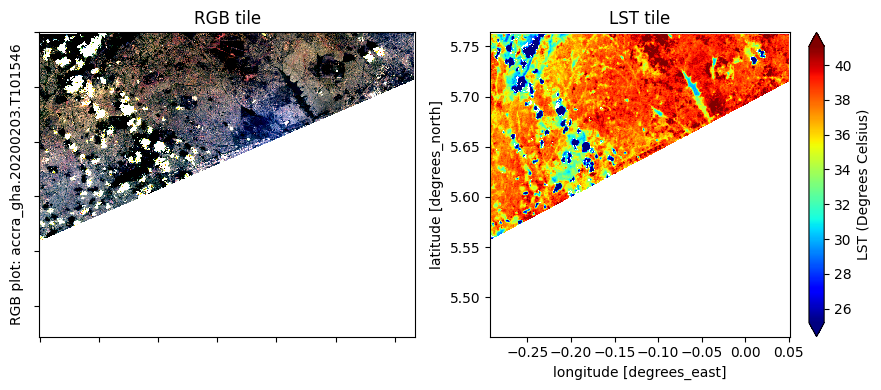

In [ ]:
# Plot the preprocessed images
plot_preprocessed_images(input_file, target_file)

## 3. Prepare tweening dataset

Here we create a dataset for tweening, or temporal gap filling. The tweening dataset consists of hourly stacked full tile inputs and is  created from the data you have downloaded and preprocessed above.

In [ ]:
# Import libraries
import os
import glob
import rasterio
import tqdm
from utils.tweening import *

#### 3.1. Set data parameters for single tile acquisition you would like to create a tweening dataset for

Edit "city_iso" for the city you are working on <br>
"hls_date" and "tile_id" can be found on the filename of the data you processed, available in ```data/processed_data/stacked-tiles/```<br>

Sample file name: <br>
```accra_gha.T30NZM.20200203.T101546.lst.tif``` <br>
```city-name_iso.tile_id.hls_date.acquisition_time.band.tif```


In [ ]:
processed_data_path = "../data/processed_data/"   #keep as is
city_iso = "johannesburg_zaf"
hls_date = "20211103"   # choose a date from data you have preprocessed
tile_id = "T35JNM"
tweening_period = 7     # days to tween for - keep as is

# path to save stacked hourly inputs
data_directory = os.path.join("../data/processed_tweening_data/")
if os.path.exists(data_directory)==False:
    os.mkdir(data_directory)

#### 3.2. Run the below cells to create the HLS and ERA5 stacked hourly inputs
Your tweening data (168 hourly geotiffs) will be saved in ```/data/processed_tweening_data/```

In [ ]:
# Gather hls bands for date and tile_id
band_string = os.path.join(processed_data_path, "hls-bands/") + city_iso + "." + tile_id + "." + hls_date + "*.tif"
hls_bands = sorted(glob.glob(band_string))

# Gather corresponding lst file
lst_string = os.path.join(processed_data_path, "target-lst/") + city_iso + "." + tile_id + "." + hls_date + "*.tif"
lst_band = glob.glob(lst_string)

# Process lst band to get grid for inputs
lst_array, grid_out, meta, crs = process_target_band(lst_band[0]) #[0] assuming there is only one lst file

# Extract arrays from individual hls bands
processed_bands = process_hls_bands(hls_bands)

# Stack these arrays
stacked = stacking(processed_bands, grid_out, crs)

# Write out the first stacked geotiff
file_name = city_iso + "." + tile_id + "." + hls_date + ".T000000.input_file.tif"
save_file = os.path.join(data_directory, file_name)
stacked.rio.to_raster(save_file, driver="COG", dtype="float32")

# Duplicate for every hour in tweening period
duplicate_hls_bands(save_file, hls_date, tweening_period, data_directory, city_iso, tile_id)

In [ ]:
# Gather input files
files_to_update = glob.glob(os.path.join(data_directory, "*.input_file.tif"))

# Gather ERA5 files for city
era5_dir = "../data/downloaded_data/era5/"
era5_cities, all_era5_inputs = files_extractor(era5_dir)
era5_city = filter_city(city_name=city_iso, lst=all_era5_inputs)

# reduce the ERA5 data - filter for the year you are considering
era5_city_year = filter_year(year= hls_date[0:4], files = era5_city)

# Update input file with ERA5 bands
with tqdm(total=len(files_to_update)) as pbar:
    for file in files_to_update:
        add_era5_stack(file, city_iso, grid_out, crs, era5_city_year)
        # remove HLS only stacked input
        os.remove(file)
        pbar.update(1)

## 4. Run inference for LST predictions

Let’s create predictions for LST for these hourly geotiffs we produced. After running the cells below, your predictions will be saved in ```/data/predictions-dsi/```

In [ ]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import glob
import os
import sys
import rasterio
import xarray as xr
import rioxarray as rx
import numpy as np
import shutil
import yaml
import pandas as pd
import pylab as plb
from pathlib import Path
sys.path.append("../")

from collections import Counter
from matplotlib.colors import Normalize
from scipy.interpolate import interpn
import matplotlib as mpl
from huggingface_hub import hf_hub_download
mpl.rcParams['agg.path.chunksize'] = 10000
import subprocess
import datetime
from datetime import datetime as dt
import rasterio as rs
from matplotlib.animation import FuncAnimation
import matplotlib
from utils.plotting import stack_rgb, load_lst, plot_rgb_and_lst, analyze_rasters
from IPython.display import Image, display
if 'google.colab' in sys.modules:
  import gdown


#matplotlib.use('Agg')
#import dask
import logging
logging.getLogger("lightning").setLevel(logging.ERROR)

#### 4.1. Model and data preparation

We start with downloading the model checkpoints from HuggingFace, the config is provided.  

In [ ]:
# Download the model checkpoints, specify the path in local_dir
ckpt_path = hf_hub_download(repo_id="ibm-granite/granite-geospatial-land-surface-temperature",
                            filename="LST_model.ckpt",
                            local_dir="../")
            #"../LST_model.ckpt"

# Download the config, specify path save directory in local_dir
config_path_full_tile = "../config_full_tile.yaml"
                        #hf_hub_download(repo_id="ibm-granite/granite-geospatial-land-surface-temperature",
                                        #filename="config_full_tile.yaml",
                                        #local_dir="../")

#### 4.2. Specify data paths

In [ ]:
# Specify path to where all data will be processed and saved - Keep below as is

data_path = Path("../data")
data_path.mkdir(parents=True, exist_ok=True)
inputs_path = "../data/processed_tweening_data/"
predictions_path = "../data/predictions-dsi/"

#### 4.3. Run inference using terratorch

Note:  Running inference might take a couple of minutes if you are using CPU only.

Ensure you have selected the correct runtimes on the Colab Notebook - Select the dropdown next to Connect on the top right hand corner > Change runtime type > ```T4 GPU or v2-8 TPU``` > save

On Colab with a T4 GPU this takes ~5 mins

In [ ]:
# Run inference
conf = yaml.safe_load(Path(config_path_full_tile).read_text())
data_bands = "[" + ",".join([str(x) for x in conf['data']['init_args']['output_bands']]) + "]"

_ = subprocess.call(['terratorch', 'predict', '-c', config_path_full_tile,
                     '--ckpt_path', str(ckpt_path),
                     '--predict_output_dir', str(predictions_path),
                     '--data.init_args.predict_data_root', str(inputs_path),
                     '--data.init_args.predict_dataset_bands', data_bands,
                     '--data.check_stackability', str(False)])

# If the above block of code using subprocess.call does not work, use the string stored in run_str to do the inferencing via the CLI.
#run_str = f"terratorch predict -c {config_path_full_tile} --ckpt_path {str(ckpt_path)} --predict_output_dir {str(predictions_path)} --data.init_args.predict_data_root {str(inputs_path)} --data.init_args.predict_dataset_bands {data_bands} --data.check_stackability False"
#print(run_str)

## 5. Reprojecting the coordinate reference system (CRS) of the predictions
To visualize the predictions and perfrom the combined mobility analyses, we would need to reproject the CRS of the data from UTC timezone to EPSG: 4326.

#### 5.1. Run the cells below to reproject your predicted LST images
The final geotiff images will be saved in ```/data/predictions-dsi/reprojected/```

In [ ]:
# import libraries
from rasterio.crs import CRS
import rioxarray as rxr
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.windows import Window
import rasterio.mask as riomask
import rasterio
from rasterio.crs import CRS
import glob
import os

In [ ]:
def reproject_crs(filename, dst_crs= 'EPSG:4326'):
    """
    reprojects .tif file into given crs
    writes reprojected version to same file
    inputs:
        filename: .tif file to reproject
    """

    src = rasterio.open(filename)
    src_crs = str(src.crs)
    transform, width, height = calculate_default_transform(
                                        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
                        'crs': dst_crs,
                        'transform': transform,
                        'width': width,
                        'height': height
                    })
    #write reprojected version to save_to
    os.makedirs("../data/predictions-dsi/reprojected/", exist_ok=True)
    save_name = filename.replace("predictions-dsi", "predictions-dsi/reprojected/")
    with rasterio.open(save_name, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

In [ ]:
files_to_reproject = glob.glob("../data/predictions-dsi/*.tif")
for file in files_to_reproject:
    reproject_crs(file)

## 6. Visualize the LST predictions using folium
Folium allows your to visualize the raster data as an overlay to a base map. Here you can explore points of interest, hotspots and cold spots.

In [ ]:
#import libraries
import folium
import numpy as np
import rasterio
import branca
import branca.colormap as cm
import folium.plugins

 #### 6.1. Edit the path in the cell below to the geotiff you want to view:

In [ ]:
with rasterio.open("../data/predictions-dsi/reprojected/accra_gha.T30NZM.20200203.T000000.inputs_pred.tif") as src:
        image_data2 = src.read(1)  # Read the first band of the raster
        bounds = [[src.bounds.bottom, src.bounds.left], [src.bounds.top, src.bounds.right]]
        center_lat = (src.bounds.top + src.bounds.bottom) / 2
        center_lon = (src.bounds.left + src.bounds.right) / 2

In [ ]:
m = folium.Map(location=[center_lat, center_lon], zoom_start=9, tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = True,
        control = True)

# if you would like to change the base map to an open street map view, comment out the above and run the below:
# m = folium.Map(location=[center_lat, center_lon], zoom_start=9, tiles='https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', attr='OpenStreetMap', name = 'OSM', overlay = True, control = True)

red_shades = ['#ffefea', '#fbd9d3', '#ffb09c', '#ee2400', '#900000']

colormap = cm.LinearColormap(colors=red_shades, vmin=0, vmax=60)


folium.raster_layers.ImageOverlay(
        image=(image_data2),
        #color=colormap,
        bounds=bounds,
        opacity=0.7,
        interactive=True,
        colormap= colormap,#lambda x: (1, 0, 0, x),
        #cross_origin=False
    ).add_to(m)

folium.LayerControl().add_to(m)

# Display the map
m

## You are now ready to proceed to the combined analysis with mobility data!
You may need to download the reprojected LST predictions you created ```/data/predictions-dsi/reprojected/``` to the desktop of this machine, or to a google drive folder.